### TensorFlow学习

网址：http://www.tensorfly.cn/tfdoc/get_started/basic_usage.html

### 1、综述

TensorFlow 是一个编程系统，使用图来表示计算任务。图中的节点被称之为op(operation 的缩写)。 一个op获得0个或多个Tensor，执行计算，产生0个或多个Tensor。每个Tensor是一个类型化的多维数组。例如，你可以将一小组图像集表示为一个四维浮点数数组，这四个维度分别是[batch, height, width, channels]。

一个TensorFlow图描述了计算的过程。为了进行计算，图必须在“会话”里被启动。“会话”将图的op分发到诸如CPU或GPU之类的设备上，同时提供执行op的方法。 这些方法执行后，将产生的tensor返回。在Python语言中，返回的tensor是numpy的ndarray对象；在C和C++语言中，返回的tensor是tensorflow::Tensor实例。

使用 TensorFlow, 必须明白TensorFlow:
* 计算模型——计算图： 使用图(graph）来表示计算任务。
* 运行模型——回话： 在被称之为会话(Session)的上下文(context)中执行图。
* 数据模型——张量： 使用tensor表示数据。
* 通过变量(Variable)维护状态。
* 使用feed和fetch可以为任意的操作(arbitrary operation)赋值或者从其中获取数据。

### 2、计算模型——计算图

构建图的第一步，是创建源op(source op)。 源op不需要任何输入，例如常量(Constant)。源op的输出被传递给其它op做运算。

Python库中,op构造器的返回值代表被构造出的op的输出,这些返回值可以传递给其它op构造器作为输入。

TensorFlow Python库有一个默认图(default graph),op构造器可以为其增加节点。这个默认图对许多程序来说已经足够用了。

In [78]:
import tensorflow as tf

# 创建一个常量op,产生一个1x2矩阵，这个op被作为一个节点
# 加到默认图中。
#
# 构造器的返回值代表该常量op的返回值。
matrix1 = tf.constant([[3., 3.]])

# 创建另外一个常量op,产生一个2x1矩阵。
matrix2 = tf.constant([[2.],[2.]])

# 创建一个矩阵乘法matmul op, 把'matrix1'和'matrix2'作为输入。
# 返回值'product'代表矩阵乘法的结果。
product = tf.matmul(matrix1, matrix2)

默认图现在有三个节点，两个constant() op，和一个matmul() op。为了真正进行矩阵相乘运算，并得到矩阵乘法的结果，必须在会话里启动这个图。

### 3、运行模型——会话

1）Session.run()启动图

构造阶段完成后，才能启动图。启动图的第一步是创建一个Session对象，如果无任何创建参数，会话构造器将启动默认图。

In [79]:
# 启动默认图.
sess = tf.Session()

# 调用sess的'run()'方法来执行矩阵乘法op,传入'product'作为该方法的参数。
# 上面提到,'product'代表了矩阵乘法op的输出,传入它是向方法表明,我们希望取回
# 矩阵乘法 op 的输出。
#
# 整个执行过程是自动化的,会话负责传递op所需的全部输入。op通常是并发执行的。
# 
# 函数调用'run(product)'触发了图中三个op(两个常量op和一个矩阵乘法op)的执行。
#
# 返回值'result'是一个numpy `ndarray`对象.
result = sess.run(product)
print(result)
# ==> [[ 12.]]

# 任务完成, 关闭会话.
sess.close()

[[ 12.]]


在实现上, TensorFlow 将图形定义转换成分布式执行的操作, 以充分利用可用的计算资源(如CPU或GPU)。 一般你不需要显式指定使用CPU还是GPU，TensorFlow能自动检测。如果检测到GPU,TensorFlow会尽可能地利用找到的第一个GPU来执行操作。

如果机器上有超过一个可用的GPU,除第一个外的其它GPU默认是不参与计算的。为了让TensorFlow使用这些GPU,你必须将op明确指派给它们执行。with...Device语句用来指派特定的CPU或GPU执行操作：

In [3]:
# with tf.Session() as sess:
#   with tf.device("/gpu:1"):
#     matrix1 = tf.constant([[3., 3.]])
#     matrix2 = tf.constant([[2.],[2.]])
#     product = tf.matmul(matrix1, matrix2)
#     ...

设备用字符串进行标识. 目前支持的设备包括:
* "/cpu:0": 机器的CPU
* "/gpu:0": 机器的第一个GPU,如果有的话
* "/gpu:1": 机器的第二个GPU,以此类推


2）交互式启动图

文档中的Python示例使用一个会话Session来启动图,并调用Session.run()方法执行操作。

为了便于使用诸如IPython之类的Python交互环境,可以使用InteractiveSession代替Session类,使用Tensor.eval()和Operation.run()方法代替Session.run()，这样可以避免使用一个变量来持有会话。

In [80]:
# 进入一个交互式TensorFlow会话.
sess = tf.InteractiveSession()

x = tf.Variable([1.0, 2.0])
a = tf.constant([3.0, 3.0])

# 使用初始化器initializer op的run()方法初始化'x' 
x.initializer.run()

# 增加一个减法subtract op,从'x'减去'a'，运行减法op,输出结果 
sub = tf.subtract(x, a)
print(sub.eval())
# ==> [-2. -1.]

[-2. -1.]


/home/liwangpei2/anaconda3/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


### 4、数据模型——张量

TensorFlow程序使用tensor数据结构来代表所有的数据,计算图中,操作间传递的数据都是tensor，你可以把,TensorFlow的数据模型tensor看作是一个n维的数组或列表。 一个tensor包含一个静态类型rank,和一个shape。

### 5、Mnist手写数字识别

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data

In [3]:
# 下载数据
mnist = input_data.read_data_sets('mnist/data/',one_hot =True)

Extracting mnist/data/train-images-idx3-ubyte.gz
Extracting mnist/data/train-labels-idx1-ubyte.gz
Extracting mnist/data/t10k-images-idx3-ubyte.gz
Extracting mnist/data/t10k-labels-idx1-ubyte.gz


In [4]:
trainimg = mnist.train.images
trainlabel = mnist.train.labels
testimg = mnist.test.images
testlabel = mnist.test.labels

In [23]:
# 训练数据有55000张图片
trainimg.shape

(55000, 784)

In [25]:
# 测试数据有10000张图片
testimg.shape

(10000, 784)

In [27]:
# 每一个样本的输出标签是一个列向量
trainlabel.shape

(55000, 10)

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
[ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]


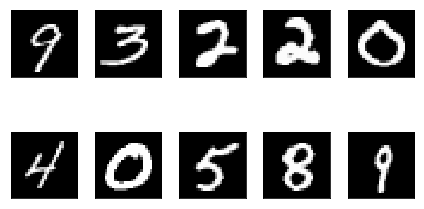

In [31]:
# 随机显示几张图片
sample = 10
randIndex = np.random.randint(trainimg.shape[0], size = sample)
fig, ax = plt.subplots(2, 5)

# flatten()函数将数组编程一维数组
ax = ax.flatten()

figIndex = 0
for index in randIndex:
#     currImg = np.reshape(trainimg[index], (28, 28))
    currImg = trainimg[index].reshape((28, 28))
    ax[figIndex].imshow(currImg, cmap='gray')
    ax[figIndex].set_xticks([])
    ax[figIndex].set_yticks([])
    figIndex += 1
    
    # 每一个样本的标签
    print(trainlabel[index])
    
plt.tight_layout()
plt.show()

In [7]:
def compute_accuracy(v_xs, v_ys):
    global prediction
    y_pre = sess.run(prediction, feed_dict={xs: v_xs, keep_prob: 1})
    correct_prediction = tf.equal(tf.argmax(y_pre,1), tf.argmax(v_ys,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    result = sess.run(accuracy, feed_dict={xs: v_xs, ys: v_ys, keep_prob: 1})
    return result

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    # stride [1, x_movement, y_movement, 1]
    # Must have strides[0] = strides[3] = 1
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    # stride [1, x_movement, y_movement, 1]
    #ksize  [1,pool_op_length,pool_op_width,1]
    # Must have ksize[0] = ksize[3] = 1
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

In [9]:
# 定义网络

# define placeholder for inputs to network
xs = tf.placeholder(tf.float32, [None, 784])    # 28x28
ys = tf.placeholder(tf.float32, [None, 10])
keep_prob = tf.placeholder(tf.float32)
x_image = tf.reshape(xs, [-1, 28, 28, 1])
# print(x_image.shape)  # [n_samples, 28,28,1]

## conv1 layer ##
W_conv1 = weight_variable([5,5, 1,32]) # patch 5x5, in size 1, out size 32
b_conv1 = bias_variable([32])
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1) # output size 28x28x32
h_pool1 = max_pool_2x2(h_conv1)                          # output size 14x14x32

## conv2 layer ##
W_conv2 = weight_variable([5,5, 32, 64]) # patch 5x5, in size 32, out size 64
b_conv2 = bias_variable([64])
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2) # output size 14x14x64
h_pool2 = max_pool_2x2(h_conv2)                          # output size 7x7x64

##flat h_pool2##
h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])  # [n_samples, 7, 7, 64] ->> [n_samples, 7*7*64]

## fc1 layer ##
W_fc1 = weight_variable([7*7*64, 1024])
b_fc1 = bias_variable([1024])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

## fc2 layer ##
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])
prediction = tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

In [ ]:
cross_entropy = tf.reduce_mean(-tf.reduce_sum(ys * tf.log(prediction),
                                              reduction_indices=[1]))       # loss
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

init = tf.global_variables_initializer()

sess = tf.Session()

sess.run(init)

for i in range(1000):
    batch_xs, batch_ys = mnist.train.next_batch(100)
    sess.run(train_step, feed_dict={xs: batch_xs, ys: batch_ys, keep_prob: 0.5})
    if i % 50 == 0:
        print(compute_accuracy(mnist.test.images, mnist.test.labels))